Von Pascal Schlaak, Tim Weise - Natural Language Processing (Prof. Dr. Bantel)

# Erste Analyse gecrawlter IMDb-Filmdaten

## Module importieren

In [1]:
import json
import spacy
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

## Daten einlesen
Wir können unseren gecrawlten, in eine Datei geschriebenen, Daten nun in ein Dictionary einlesen.

In [2]:
# Pfad zu JSON-Datei
PATH_TO_DATA = '../data/movies.json'
# Einlesen der JSON-Datei in Dictionary
data = pd.read_json(PATH_TO_DATA)

Wir erhalten folgende Rohdaten:

In [4]:
data

,title,date,rank,synopsis
0,The Shawshank Redemption,1994,1,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
1,The Dark Knight,2008,3,The movie begins with a gang of men with clown...
2,The Godfather,1972,2,"In late summer 1945, guests are gathered for t..."
3,The Godfather: Part II,1974,4,The Godfather Part II presents two parallel st...
4,Pulp Fiction,1994,6,"Late one morning in the Hawthorne Grill, a res..."
...,...,...,...,...
245,Green Book,2018,125,"In 1962 in New York City, Tony ""Tony Lip"" Vall..."
246,The Kid,1921,124,\n It looks like we don't have ...
247,Metropolis,1927,123,(This is the synopsis of the full 150 minute v...
248,"Three Billboards Outside Ebbing, Missouri",2017,126,Mildred Hayes drives down Drinkwater Road near...


In [5]:
data.sort_values(by=['rank'])

,title,date,rank,synopsis
0,The Shawshank Redemption,1994,1,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,The Godfather,1972,2,"In late summer 1945, guests are gathered for t..."
1,The Dark Knight,2008,3,The movie begins with a gang of men with clown...
3,The Godfather: Part II,1974,4,The Godfather Part II presents two parallel st...
5,The Lord of the Rings: The Return of the King,2003,5,"In the opening scene, a flashback, two hobbits..."
...,...,...,...,...
183,The General,1926,246,"The Western & Atlantic Flyer ""speeds into Mari..."
179,The Help,2011,247,"In civil-rights era Jackson, Mississippi, 23-y..."
178,Before Sunset,2004,248,Nine years have passed since the events of Bef...
177,"Monsters, Inc.",2001,249,The city of Monstropolis in a world entirely p...


## Tokenisierung
Für eine erste Analyse unserer Daten können wir uns einen spezifizierten Eintrag der Datei näher anschauen.

In [6]:
# Laden des Sprach-Supports für spätere Analysen wie POS-Tagging
nlp = spacy.load("en_core_web_sm")
# Tokenisieren der Zusammenfassung des Films: Godfellas
document = nlp(data['synopsis'][0])

Wir erhalten folgende Textdaten:

In [7]:
document

In 1947, Andy Dufresne (Tim Robbins), a banker in Maine, is convicted of murdering his wife and her lover, a golf pro. Since the state of Maine has no death penalty, he is given two consecutive life sentences and sent to the notoriously harsh Shawshank Prison. Andy keeps claiming his innocence, but his cold and calculating demeanor leads everyone to believe he did it.Meanwhile, Ellis Boyd Redding (Morgan Freeman), known as Red is being interviewed for parole after having spent 20 years at Shawshank for murder. Despite his best efforts and behavior, Red's parole is rejected which doesn't phase him all that much. Red is then introduced as the local smuggler who can get inmates anything they want within reason. An alarm goes off alerting all prisoners of new arrivals. Red and his friends bet on whichever new fish will have a nervous break down during his first night in prison. Red places a huge bet on Andy.During the first night, an overweight newly arrived inmate, nicknamed ''fat ass', b

## POS-Tagging

Wir können nun untersuchen, ob *spaCy* eine erfolgreiche Lemmatisierung/POS-Tagging des englischen Textes ermöglicht. Hierfür nutzen wir die bereits integrierten Tags.

In [8]:
pos = [{'Text': token.text, 'Lemma': token.lemma_, 'POS tag': token.pos_, 'Shape': token.shape_, 'Alpha': token.is_alpha, 'Stop': token.is_stop, 'Entity': token.ent_type_} for token in document]
tokens = pd.DataFrame(pos)

In [9]:
tokens

,Text,Lemma,POS tag,Shape,Alpha,Stop,Entity
0,In,in,ADP,Xx,True,True,
1,1947,1947,NUM,dddd,False,False,DATE
2,",",",",PUNCT,",",False,False,
3,Andy,Andy,PROPN,Xxxx,True,False,PERSON
4,Dufresne,Dufresne,PROPN,Xxxxx,True,False,PERSON
...,...,...,...,...,...,...,...
4139,had,have,AUX,xxx,True,True,
4140,been,be,AUX,xxxx,True,True,
4141,hoping,hope,VERB,xxxx,True,False,
4142,for,for,ADP,xxx,True,True,


Betrachten wir beispielsweise die Ausgabe des siebenten Wortes *driving*, können wir die Funktionlität von spaCy validieren. Wir erhalten *drive* als Grundform des Wortes. Es handelt sich um ein Verb, welches kein Stoppwort darstellt.

In [14]:
tokens.loc[18]

Text       murdering
Lemma         murder
POS tag         VERB
Shape           xxxx
Alpha           True
Stop           False
Entity              
Name: 18, dtype: object

## Token Häufigkeit (gesamt)

Wir können nun mit einer konkreten Analyse des Textes fortfahren. Hierfür Tokenisieren wir unsere Textdaten und entfernen alle Stoppwörter und Satzzeichen. Diese geben uns wenige Hinweise auf den konkreten Inhalt des Films. Wir zählen ebenfalls die Häugigkeit aller Wörter und erstellen eine Liste von (Eigen-)namen für die weitere Analyse.

In [15]:
# Alle Token in Liste speichern
words = [token.text for token in document]
# Häufigkeit für jedes Token berechnen
counters = Counter(words)

In [16]:
# Neues DataFrame erstellen
frequency = pd.DataFrame(columns=['Frequency'])
# Häufigkeit der Token zuweisen
frequency['Frequency'] = pd.Series(counters)
# Absteigend sortieren
frequency = frequency.sort_values(by=['Frequency'], ascending=False)

In [17]:
frequency

,Frequency
the,193
.,174
",",147
to,119
Andy,110
...,...
weeks,1
stretch,1
easiest,1
stuck,1


Die gecrawlten Zusammenfassungen verschiedener Filme sollten uns somit generell eine gute Datenbasis für weitere Analysen bieten, insofern die Länge der aktuellen Filmbeschreibung keine Ausnahme war. 

Wir können uns nun beispielsweise die 30 am häufigsten vorkommenden Wörter der Zusammenfassung plotten.

In [18]:
common_tokens = dict(Counter(words).most_common(20))

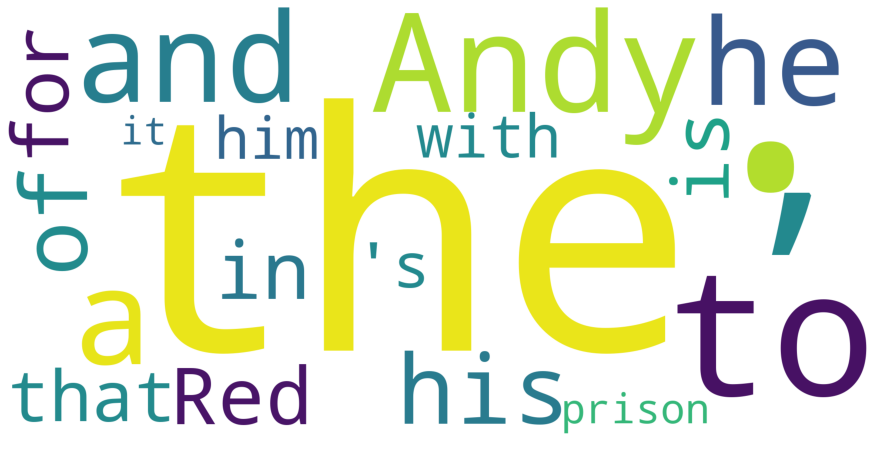

In [19]:
word_cloud = WordCloud(background_color="white", width=2000, height=1000,).generate_from_frequencies(common_tokens)
plt.rcParams["figure.figsize"] = (16, 8)
plt.axis("off")
plt.imshow(word_cloud)

## Worthäufigkeit (ohne Satzzeichen und Stoppwörter)

In [20]:
# Alle Wörter in Liste speichern
words = [token.text for token in document if not token.is_stop and not token.is_punct]
# Worthäufigkeit berechnen
counters = Counter(words)

In [21]:
# Neues DataFrame erstellen
frequency = pd.DataFrame(columns=['Frequency'])
# Häufigkeit der Token zuweisen
frequency['Frequency'] = pd.Series(counters)

In [22]:
common_words = dict(Counter(words).most_common(20))

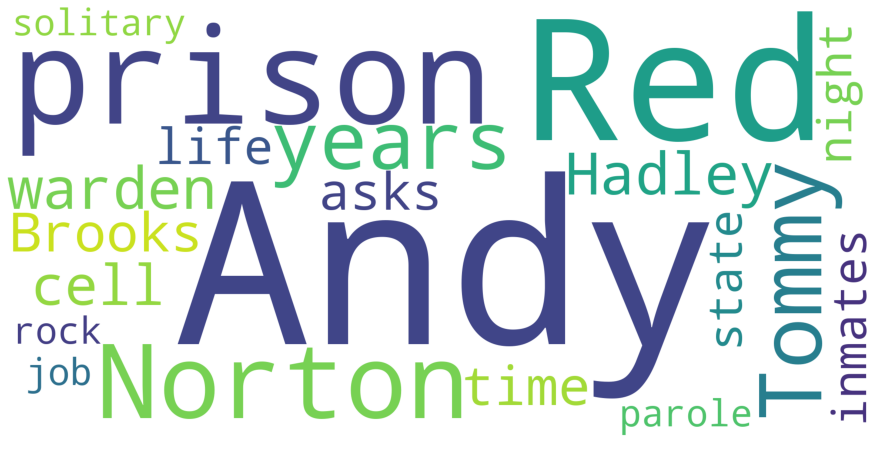

In [23]:
word_cloud = WordCloud(background_color="white", width=2000, height=1000,).generate_from_frequencies(common_words)
plt.rcParams["figure.figsize"] = (16, 8)
plt.axis("off")
plt.imshow(word_cloud)

## Worthäufigkeit (ohne Satzzeichen, Stoppwörter und Eigennamen)

In [24]:
# Eigennamen identifizieren
entities = sorted(set([entity.text for entity in document.ents]))
# Token auf Wörter ohne Eigennamen, Stoppwörter, Satzzeichen reduzieren
words = [token.lemma_ for token in document if token.text not in entities and not token.is_stop and not token.is_punct]
# Worthäufigkeit berechnen
counters = Counter(words)

In [25]:
# Neues DataFrame erstellen
frequency = pd.DataFrame(columns=['Frequency'])
# Häufigkeit der Token zuweisen
frequency['Frequency'] = pd.Series(counters)

In [26]:
common_words = dict(Counter(words).most_common(20))

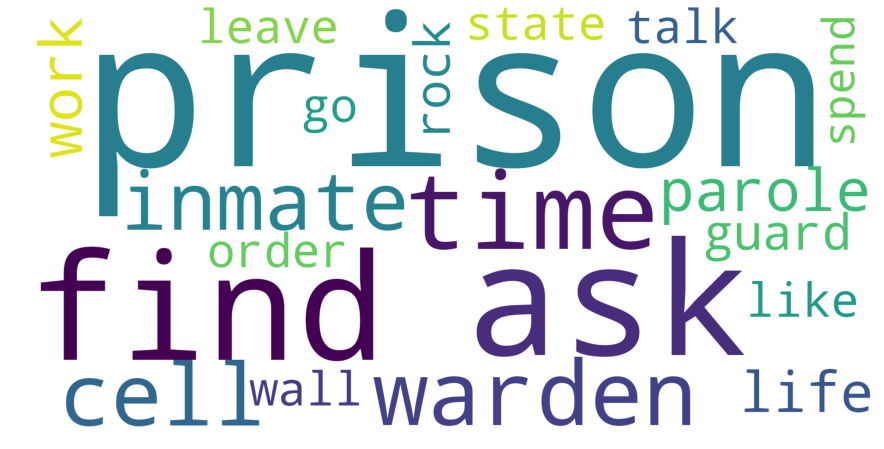

In [27]:
word_cloud = WordCloud(background_color="white", width=2000, height=1000,).generate_from_frequencies(common_words)
plt.rcParams["figure.figsize"] = (16, 8)
plt.axis("off")
plt.imshow(word_cloud)

Wir können erkennen, dass diese Zusammenfassung von Godfellas des öfteren die Namen der Rollen beinhaltet. Ebenfalls können wichtige Rückschlüsse auf die Handlung gezogen werden. Basierend auf der Zusammenfassung der Handlung scheint es sich bei Godfellas um ein gewaltvollen Krimi zu handeln, der sich ebenfalls mit Drogen, Morden, Schusswechsel und der Polizei auseinandersetzt. Interessanterweise kommt das Wort "Mafia" nicht unter den 25 am häufigsten verwendeten Wörtern vor. Wir können dennoch untersuchen, ob Mafia mindestens ein mal erwähnt wird. Hierfür suchen wir nach Mafia als Key in unserem frequencies-Dictionary in Groß- und Kleinschreibung:

Unsere Zusammenfassung enthält anscheinend nur ein mal das Wort Mafia. Wir können uns ebenfalls ein Set der verwendeten (Eigen-)namen ausgeben. Diese könnte uns weitere Rückschlüsse auf die Zeit der Handlung, Spielorte, Figuren, Darsteller und weitere wichtige Informationen bieten.

## Eigennamen

In [29]:
spacy.displacy.render(document, style="ent", jupyter=True)

### Personen / Rollen

In [30]:
set([token.text for token in document.ents if token.label_ == 'PERSON'])

{'Andy',
 'Andy Dufresne',
 'Bible',
 'Bob Gunton',
 'Boggs',
 'Brooks',
 'Brooks Hatlen',
 'Byron Hadley',
 'Clancy Brown',
 'Ellis Boyd Redding',
 'Gil Bellows',
 'Hadley',
 'Heywood',
 'James Whitmore',
 'Marilyn Monroe',
 'Mark Rolston',
 'Mozart',
 'Randall Stephens',
 'Raquel Welch',
 'Red',
 'Rita Hayworth',
 'Shawshank Prison',
 'Tim Robbins',
 'Tommy',
 'Warden Norton',
 "Warden Norton's",
 'Warden Samuel Norton',
 'William Sadler',
 'Zihuatanejo',
 'hammer'}

### Orte

In [31]:
set([token.text for token in document.ents if token.label_ == 'GPE'])

{'Buxton',
 'Fort Hancock',
 'Haywood',
 'Maine',
 'Mexico',
 'Portland',
 'Red',
 'Texas',
 'Zihuatanejo'}

### Zeiten

In [32]:
set([token.text for token in document.ents if token.label_ == 'DATE'])

{'10 years',
 '13 years old',
 '1947',
 '1965',
 '1967',
 '20 years',
 '30 years',
 '50 years',
 'About a month later',
 'About four years',
 'a month',
 'a week',
 'almost 20 years',
 'another month',
 'every week',
 "lays within''",
 'ten years earlier',
 'the first two years',
 'the years',
 'two weeks',
 'years'}

Es könnte sich hierbei um eine Geschichte der irischen Mafia handeln, beginnend in den 1950er Jahren. Robert de Niro und Joe Pesci scheinen eine Rolle zu verkörpern. Spielort könnte New York sein.

## Vorverarbeitung der Daten

In [33]:
lemmas = []
for token in document:
    # Nimm lemmatisiertes Token falls kein Eigenname, Stoppwort und Satzzeichen
    if not token.ent_type_ and not token.is_stop and not token.is_punct:
        lemmas.append(token.lemma_)
bag_of_words = ' '.join(lemmas)

In [34]:
bag_of_words

'banker convict murder wife lover golf pro state death penalty give consecutive life sentence send notoriously harsh keep claim innocence cold calculate demeanor lead believe know Red interview parole have spend murder despite good effort behavior parole reject phase Red introduce local smuggler inmate want reason alarm go alert prisoner new arrival Red friend bet whichever new fish nervous break prison red place huge bet night overweight newly arrive inmate nickname fat ass break cry hysterically allow win bet celebration short live chief guard savagely beat fat man keep quiet ask remain steadfast compose inmate learn fat ass die infirmary prison doctor inquire man approach Red have hear talent find thing ask Red find rock hammer instrument claim necessary hobby rock collecting sculpting Red ask question intention laugh Red agree place order warn sister group prisoner sexually assault prisoner importantly leader crush prisoner consider cold fish Red see like start Red think intend use

# Bag of Words

In [35]:
# Matrix von Token mit Frequenz plus Normalisieren mittels "Inverse-document-frequency" (IDF)
vectorizer = TfidfVectorizer()
# Lernen des Vokabulars und IDF
X = vectorizer.fit_transform([bag_of_words])

In [36]:
X.shape

(1, 707)

In [37]:
X.toarray()

array([[0.02156154, 0.01078077, 0.02156154, 0.01078077, 0.01078077,
        0.01078077, 0.01078077, 0.01078077, 0.01078077, 0.01078077,
        0.01078077, 0.02156154, 0.01078077, 0.01078077, 0.01078077,
        0.01078077, 0.05390385, 0.03234231, 0.01078077, 0.01078077,
        0.04312308, 0.01078077, 0.03234231, 0.01078077, 0.01078077,
        0.01078077, 0.01078077, 0.02156154, 0.01078077, 0.02156154,
        0.01078077, 0.02156154, 0.01078077, 0.1832731 , 0.02156154,
        0.01078077, 0.02156154, 0.01078077, 0.01078077, 0.01078077,
        0.01078077, 0.03234231, 0.01078077, 0.01078077, 0.02156154,
        0.03234231, 0.01078077, 0.01078077, 0.01078077, 0.02156154,
        0.03234231, 0.04312308, 0.01078077, 0.02156154, 0.01078077,
        0.01078077, 0.01078077, 0.02156154, 0.03234231, 0.01078077,
        0.03234231, 0.01078077, 0.02156154, 0.03234231, 0.01078077,
        0.07546539, 0.01078077, 0.02156154, 0.06468462, 0.02156154,
        0.01078077, 0.01078077, 0.01078077, 0.01

In [38]:
np.max(X.toarray())

0.48513467051486314

In [39]:
vectorizer.get_feature_names()

['able',
 'accord',
 'account',
 'accounting',
 'act',
 'action',
 'actress',
 'actual',
 'adapt',
 'adjust',
 'adult',
 'advise',
 'advising',
 'after',
 'age',
 'ago',
 'agree',
 'alarm',
 'alert',
 'allegedly',
 'allow',
 'angry',
 'announce',
 'answer',
 'anymore',
 'appear',
 'appreciate',
 'approach',
 'area',
 'arrest',
 'arrival',
 'arrive',
 'aside',
 'ask',
 'ass',
 'assault',
 'assign',
 'assist',
 'assumed',
 'attorney',
 'avoid',
 'away',
 'badly',
 'bag',
 'bank',
 'banker',
 'bar',
 'basis',
 'bathroom',
 'beach',
 'beam',
 'beat',
 'beating',
 'beer',
 'befriend',
 'begin',
 'behalf',
 'behavior',
 'believe',
 'belonging',
 'bet',
 'birth',
 'black',
 'board',
 'boast',
 'book',
 'bother',
 'box',
 'break',
 'breaking',
 'bribe',
 'brief',
 'bring',
 'brook',
 'brutally',
 'buddy',
 'budget',
 'build',
 'building',
 'bunch',
 'burn',
 'bus',
 'buy',
 'calculate',
 'campaign',
 'captivate',
 'car',
 'carve',
 'case',
 'cash',
 'cashier',
 'catch',
 'celebration',
 'cell'

## Fazit
Eine erste Analyse einer gecrawlten IMDb-Zusammenfassung des Filmes Godfellas mit Python und spaCy liefert einen vielversprechenden Ansatz, welcher im Folgenden weiter verfolgt wird. Im nächten Schritt soll eine Analyse aller Einträge des Crawlings untersucht werden. Hierbei ist es wichtig mit der Verarbeitung vieler Daten zu beschäftigen.